# Phase 4 Project Submission¶
- Student name: Lucas Wilkerson
- Student pace: Flex/part time
- Scheduled project review date/time:
- Instructor name: Morgan Jones

# Pneumonia Detection and Classification

## Project Overview

For this project, the aim is to build a model for image classification that can classify whether a patient has pneumonia when provided a chest x-ray image. 

## Business Problem and Stakeholder

A healthcare physician group is looking to improve their patient outcomes, specifically patients who are being diagnosed with pneumonia. Pneumonia is a significant health concern among patients, especially geriatric and pediatric patients. For effective treatment and the best possible outcomes, early detection and diagnosis is crucial. Current methods for diagnosing pneumonia can be time-consuming and can be prone to error. Through the development and use of method such as image classification and deep learning, we may be able to improve this process which can lead to an increase in early accurate identification and as a result improve patient outcomes.


## Data Understanding

The dataset used for this project contains chest X-ray images from pediatric patients with or without pneumonia who are ages one to five who. The dataset is already separated and organized into three groups:

- Train: data used for training the model
- Test: data used for testing and evaluating the model's performance 
- Validation: data used during the training process to help tune the model



## Data Preparation/ Preprocessing

To start the preparation and preprocessing phase, the necessary packages will be imported for this project. Next a directory path will be made to each of the three dataset groups: training data, test data, validation data. The images will be loaded and also rescaled. 


In [2]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from sklearn.utils import class_weight , compute_class_weight


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras.optimizers import Adam , SGD, RMSprop
from keras.utils import array_to_img, img_to_array, load_img
from keras.regularizers import l1 , l2 
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine


In [3]:
# Creating directory path for loading datasets
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

In [12]:
# Function to get the number of images in each directory
def get_directory_counts(directory):
    directory_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            directory_counts[class_name] = num_images
    return directory_counts

# Get the number of images in each directory for train, test, and validation directories
train_directory_counts = get_directory_counts('chest_xray/train')
test_directory_counts = get_directory_counts('chest_xray/test')
val_directory_counts = get_directory_counts('chest_xray/val')

# Print the results
print("Train Directory Counts:", train_directory_counts)
print("Test Directory Counts:", test_directory_counts)
print("Validation Directory Counts:", val_directory_counts)


Train Directory Counts: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Test Directory Counts: {'PNEUMONIA': 390, 'NORMAL': 234}
Validation Directory Counts: {'PNEUMONIA': 8, 'NORMAL': 8}


In [19]:
# Performing data augmentmentation to adjust for class imbalance with the training set
# All images will be rescaled by 1./255
# Seting target size of images to 100 x 100
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Getting all training data (5216 images) 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, 
        class_mode='binary')

# Getting all the test data (624 images)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624,
        class_mode='binary')


# Getting all the validation data (16 images)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, 
        class_mode='binary')

# Creating the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Data Analysis/ Data Visualization

In [28]:
# Function to get class counts
def get_class_counts(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_counts_dict = dict(zip(unique_classes, class_counts))
    return class_counts_dict

# Get class counts for each dataset
train_class_counts = get_class_counts(train_labels)
test_class_counts = get_class_counts(test_labels)
val_class_counts = get_class_counts(val_labels)

# Print class counts
print("Train Class Counts:", train_class_counts)
print("Test Class Counts:", test_class_counts)
print("Validation Class Counts:", val_class_counts)

# Viewing class indices
train_generator.class_indices


Train Class Counts: {0.0: 1341, 1.0: 3875}
Test Class Counts: {0.0: 234, 1.0: 390}
Validation Class Counts: {0.0: 8, 1.0: 8}


{'NORMAL': 0, 'PNEUMONIA': 1}

In [21]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print("Train:", train_images.shape)
print("Test:", test_images.shape)
print("Validation:", val_images.shape)

print("Label Dataset Shape")
print("Train:", train_labels.shape)
print("Test:", test_labels.shape)
print("Validation:", val_labels.shape)



Image Dataset Shape
Train: (5216, 256, 256, 3)
Test: (624, 256, 256, 3)
Validation: (16, 256, 256, 3)
Label Dataset Shape
Train: (5216,)
Test: (624,)
Validation: (16,)


In [41]:
# Reshaping image datasets for future modeling 
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)


# Reshaping labels for modeling
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 196608)
(624, 196608)
(16, 196608)
(5216, 1)
(624, 1)
(16, 1)


Looking at the characteristics of the datasets, we can derive the total number of images per group, along with the size of each image, and the class indices for labeling. Images labeled with a 0 are classified as Normal while images labeled with a 1 are classified as having Pneumonia. 

Training set: 5216 images 
- Pneumonia: 3875
- Normal: 1341

Test set: 624 images 
- Pneumonia: 390
- Normal: 234

Validation set: 16 images
- Pneumonia: 8
- Normal: 8

Image size: 256 x 256 x 3


From the image above, we can see this an example of a individual without pneumonia. 

1.0


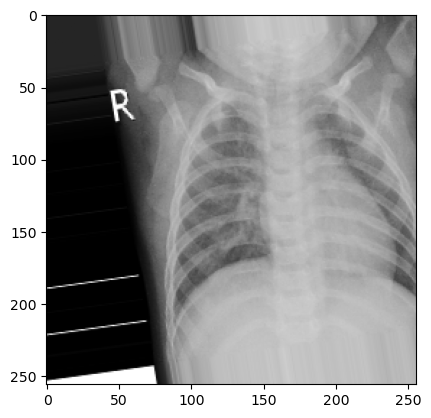

In [38]:
# Previewing sample image from training set
example_img = train_images[6]
plt.imshow(example_img)
print(train_labels[6])

From the image above, we can see this an example of a individual with pneumonia. 

### Class Distribution

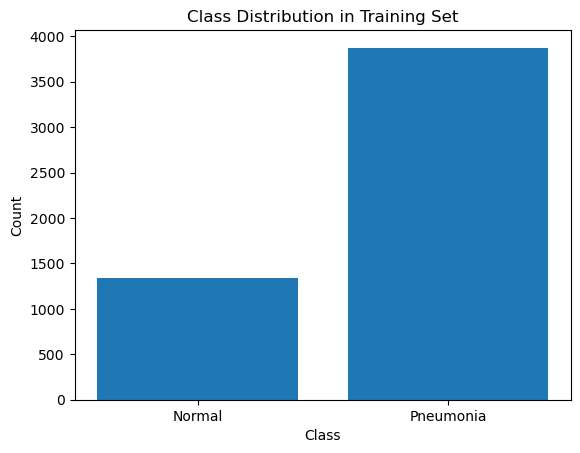

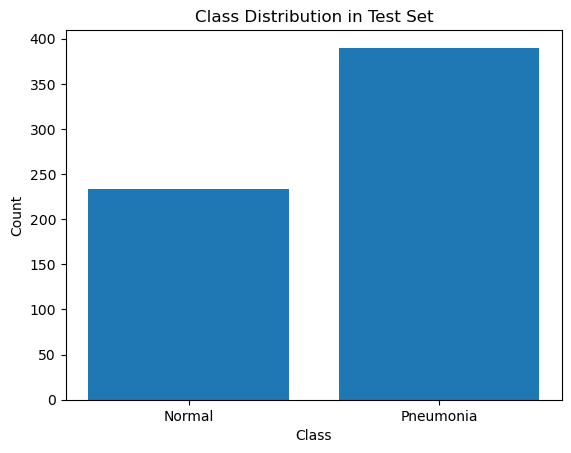

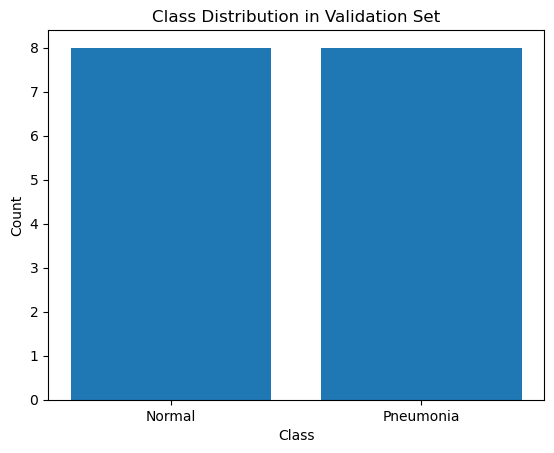

In [40]:
# Get class counts for each set
train_class_counts = np.unique(train_labels, return_counts=True)
test_class_counts = np.unique(test_labels, return_counts=True)
val_class_counts = np.unique(val_labels, return_counts=True)

# Define class labels
class_labels = {0: 'Normal', 1: 'Pneumonia'}

# Plot class distribution
def plot_class_distribution(class_counts, dataset):
    classes, counts = class_counts
    plt.bar(classes, counts)
    plt.title(f'Class Distribution in {dataset} Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(list(class_labels.keys()), [class_labels[c] for c in classes])  # Set x-axis ticks with labels
    plt.show()

# Plot for training set
plot_class_distribution(train_class_counts, 'Training')

# Plot for test set
plot_class_distribution(test_class_counts, 'Test')

# Plot for validation set
plot_class_distribution(val_class_counts, 'Validation')

Looking at the whole dataset, there is a total of 5856 images. As mentioned previously, the training set contains 5216 images, the validation set contains 16 images and the test set contains 624 images. 

- The training set has 3875 images labeled with pneumonia while having 1341 labeled as normal/without pneumonia. This image set seems to have an imbalanced class distribution since there are a long more images with pneumonia. This class imbalance could affect the model's performance and ability to generalize over the data. 
- The validation set has small number of images for both classes with 8 images labeled with pneumonia while having 8 labeled as normal/without pneumonia. 
- The test set has 390 images labeled with pneumonia while having 234 labeled as normal/without pneumonia. This image appears to have a more balanced distribution in comparison to the training set. Even though the the pneumonia images count is still higher than the images without pneumonia, the difference is not as vast as the training set. 

## Data Modeling 

To start, we'll be building a simple neural network model as our baseline model for pneumonia classficiation. Based on the results, I plan to adjust and iterate as needed to find the optimal best performing model. First I plan to test these models on a smaller subset of the training data for speed of runtimes. After best model is determined, the whole dataset will be utilized. 

In [51]:
# Set the seed for reproducibility
np.random.seed(42)

# Define the size of the subsample
subsample_size = 2500  

# Randomly select indices for the subsample
subsample_indices = np.random.choice(train_img.shape[0], subsample_size, replace=False)

# Create the subsampled training set
subsample_train_img = train_img[subsample_indices]
subsample_train_y = train_y[subsample_indices]

# Print the shape of the subsampled datasets
print(subsample_train_img.shape)
print(subsample_train_y.shape)

(2500, 196608)
(2500, 1)


### Baseline Model 

In [52]:
# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12)                2359308   
                                                                 
 dense_7 (Dense)             (None, 8)                 104       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Fitting the model to the training data
results_1 = model_1.fit(subsample_train_img, subsample_train_y, 
                        epochs=30, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))

Epoch 1/30
50/50 [==============================] - 11s 213ms/step - loss: 0.2749 - accuracy: 0.8872 - val_loss: 1.2984 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 7s 131ms/step - loss: 0.2189 - accuracy: 0.9156 - val_loss: 1.4698 - val_accuracy: 0.5625
Epoch 3/30
50/50 [==============================] - 5s 105ms/step - loss: 0.2307 - accuracy: 0.9020 - val_loss: 1.0153 - val_accuracy: 0.6250
Epoch 4/30
50/50 [==============================] - 6s 128ms/step - loss: 0.2249 - accuracy: 0.9084 - val_loss: 0.8512 - val_accuracy: 0.7500
Epoch 5/30
50/50 [==============================] - 7s 138ms/step - loss: 0.2733 - accuracy: 0.8892 - val_loss: 1.9157 - val_accuracy: 0.5000
Epoch 6/30
50/50 [==============================] - 7s 139ms/step - loss: 0.4366 - accuracy: 0.8220 - val_loss: 1.2083 - val_accuracy: 0.5625
Epoch 7/30
50/50 [==============================] - 7s 137ms/step - loss: 0.2309 - accuracy: 0.9016 - val_loss: 0.9657 - val_accuracy: 0.7500
Epoch

In [67]:
# Training Results 
results_train = model_1.evaluate(subsample_train_img, subsample_train_y)

# Test Results 

results_test = model_1.evaluate(test_img, test_y)

20/20 [==============================] - 3s 129ms/step - loss: 1.3291 - accuracy: 0.6122


In [68]:
print('Train Results:', results_train)
print('Test Results:', results_test)

Train Results: [0.2790633738040924, 0.8700000047683716]
Test Results: [1.3291044235229492, 0.6121794581413269]


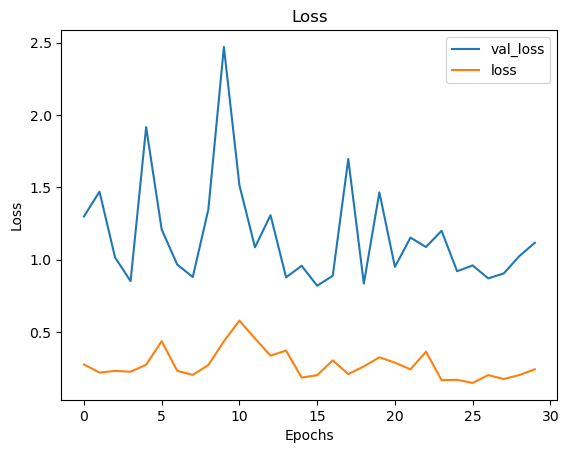

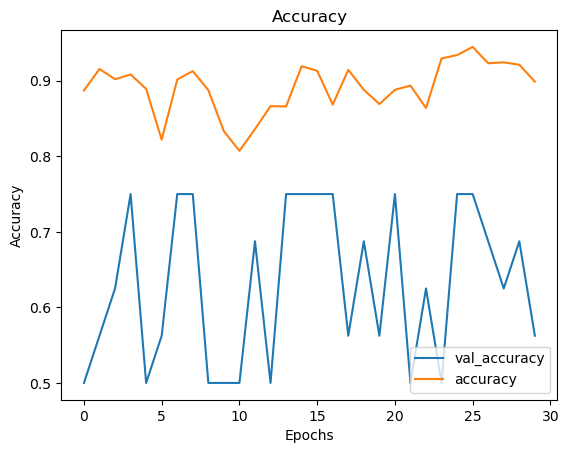

In [69]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_1)

### Model 2

In [70]:
# Model 2 changing activation function in first 2 layers

model_2 = Sequential()
model_2.add(Dense(32, activation='relu', input_shape=(196608,)))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_2.summary()

# Fitting the model to the training data
results_2 = model_2.fit(subsample_train_img, subsample_train_y, 
                        epochs=30, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                6291488   
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,292,161
Trainable params: 6,292,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 14s 242ms/step - loss: 1.2442 - accuracy: 0.6736 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
50/50 [===============

In [71]:
# Training Results 
results2_train = model_2.evaluate(subsample_train_img, subsample_train_y)

# Test Results 

results2_test = model_2.evaluate(test_img, test_y)

20/20 [==============================] - 3s 111ms/step - loss: 0.6755 - accuracy: 0.6250


In [72]:
print('Train Results:', results2_train)
print('Test Results:', results2_test)

Train Results: [0.5819567441940308, 0.7336000204086304]
Test Results: [0.6754531860351562, 0.625]


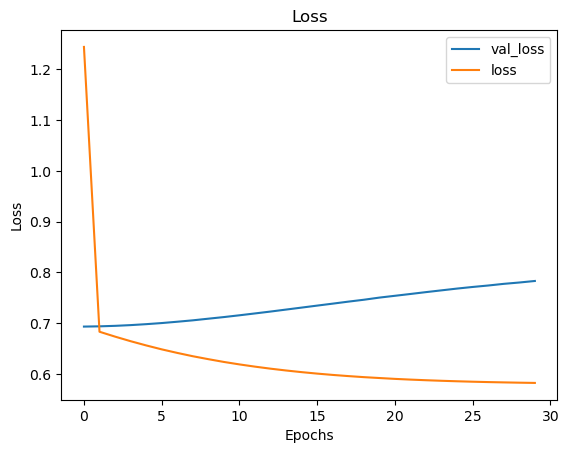

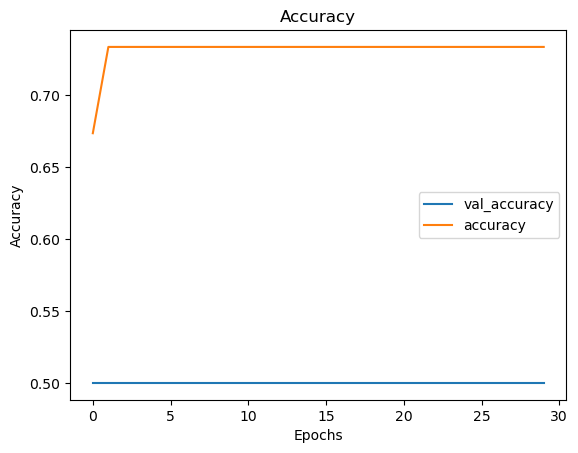

In [73]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_2)

### Model 3

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                12582976  
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 28s 512ms/step - loss: 7.0318 - accuracy: 0.6152 - val_loss: 3.5087 - val_accuracy: 0.5000
Epoch 2/30
50/50 [=============

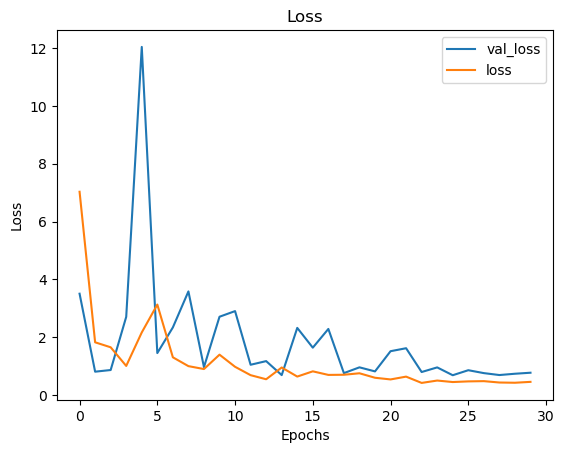

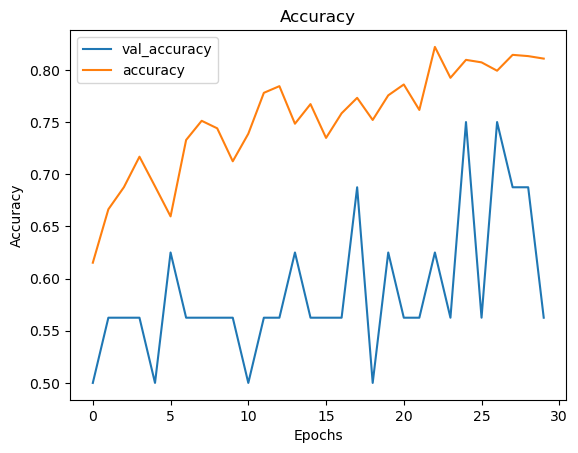

In [74]:
# Model 3 
# Adding more neurons per layer 

model_3 = Sequential()
model_3.add(Dense(64, activation='relu', input_shape=(196608,)))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_3.summary()

# Fitting the model to the training data
results_3 = model_3.fit(subsample_train_img, subsample_train_y, 
                        epochs=30, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))

# Training Results 
results3_train = model_3.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results3_test = model_3.evaluate(test_img, test_y)

print('Train Results:', results3_train)
print('Test Results:', results3_test)

# Viewing results 
visualize_training_results(results_3)

### Model 4

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                12582976  
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 27s 475ms/step - loss: 2.1780 - accuracy: 0.6080 - val_loss: 0.7998 - val_accuracy: 0.5625
Epoch 2/50
50/50 [=============

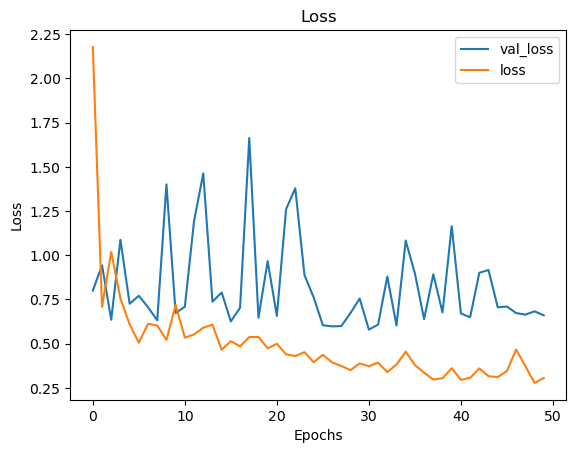

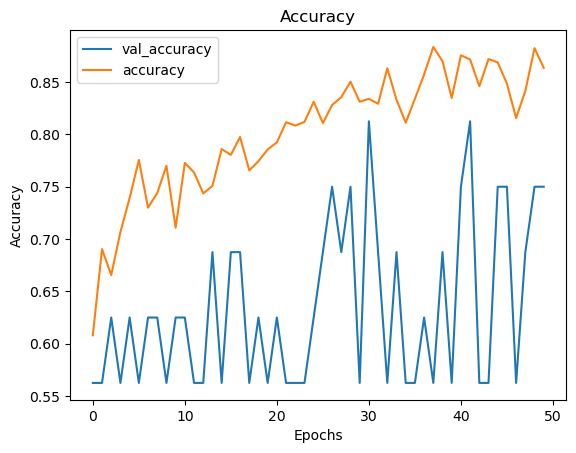

In [75]:
# Model 4
# increased epoch to 50

model_4 = Sequential()
model_4.add(Dense(64, activation='relu', input_shape=(196608,)))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_4.summary()

# Fitting the model to the training data
results_4 = model_4.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))

# Training Results 
results4_train = model_4.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results4_test = model_4.evaluate(test_img, test_y)

print('Train Results:', results4_train)
print('Test Results:', results4_test)

# Viewing results 
visualize_training_results(results_4)

Train Accuracy: 0.9016
Test Accuracy: 0.7003

### Model 5

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                12582976  
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 37s 664ms/step - loss: 7.0419 - accuracy: 0.6288 - val_loss: 3.2261 - val_accuracy: 0.5625
Epoch 2/50
50/50 [=============

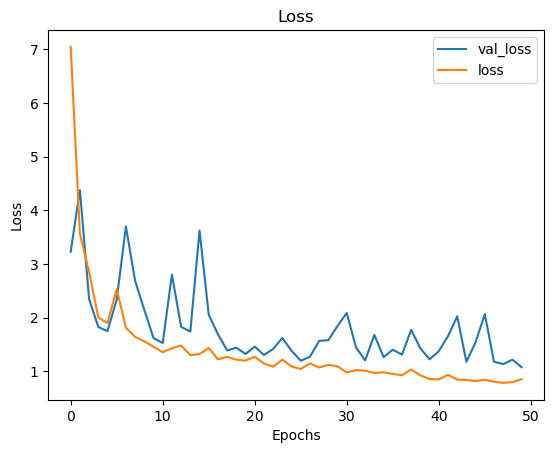

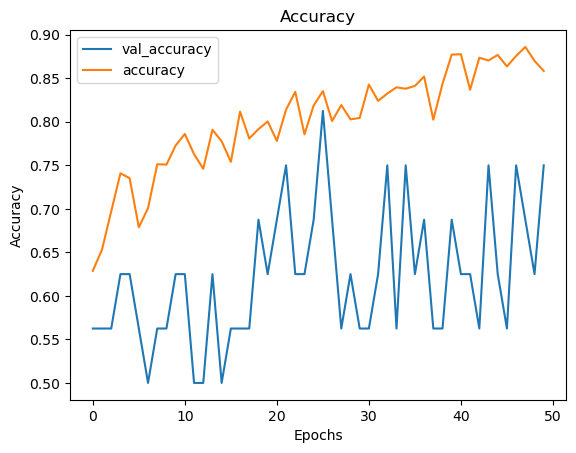

In [79]:
# Model 5
# epoch at 50
# adding l2 regularizer

model_5 = Sequential()
model_5.add(Dense(64, activation='relu', input_shape=(196608,)))
model_5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_5.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_5.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_5.summary()

# Fitting the model to the training data
results_5 = model_5.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y), 
                        verbose=1)

# Training Results 
results5_train = model_5.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results5_test = model_5.evaluate(test_img, test_y)

print('Train Results:', results5_train)
print('Test Results:', results5_test)

# Viewing results 
visualize_training_results(results_5)

### Model 6

### Model 7

### Model 8

### Model 9

## Building a Convolutional Neural Network Model
### Baseline CNN

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Define the size of the subsample
subsample_size = 2500  

# Randomly select indices for the subsample
subsample_indices = np.random.choice(train_img.shape[0], subsample_size, replace=False)

# Create the subsampled training set
cnn_subsample_train_img = train_images[subsample_indices]
cnn_subsample_train_y = train_labels[subsample_indices]

# Print the shape of the subsampled datasets
print(cnn_subsample_train_img.shape)
print(cnn_subsample_train_y.shape)

In [ ]:
# cnn baseline model

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters= 8, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

# Inspecting model summary
cnn_model.summary()

# Fit and train the model 
cnn_model.fit(train_images, train_labels, epochs=10, batch_size=128)

# Evaluate the model 
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print(test_acc)


### CNN Model 2

## Evaluation 

## Conclusion and Recommendations 

## Limitations and Future Considerations